In [50]:
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,train_test_split
import os,tabulate
from sklearn.linear_model import ElasticNet
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import warnings


# Performing Data Wrangling

---
**Performing data cleaning,handling missing values, and outliers by clipping, feature engineering, data enrichment etc.**

In [51]:
warnings.filterwarnings("ignore")
def cleanMydataset(dataset):
        df = dataset.copy()
        df = df.dropna(axis=1, how='all')
        df = df.dropna(how='all')
# Remove duplicates
        today = date.today()
        df = df.drop_duplicates()
        df["starttime"] = pd.to_datetime( str(today)+" " +df["starttime"].astype(str),errors='coerce')
        for column in df.columns:
                if column == "starttime":
                        df[column]=df[column].bfill()
                        df[column]=df[column].ffill()
                if column == "gender":
                        df[column]=df[column].astype(str)        
                if pd.api.types.is_numeric_dtype(df[column]) and df[column].isna().any():
                        df[column]=df[column].fillna(round(df[column].mean(),2))
                        Q1 = df[column].quantile(0.25)
                        Q3 = df[column].quantile(0.75)
                        IQR = Q3 - Q1
                        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
                        in_range_mean = df[column][(df[column] >= lower) & (df[column] <= upper)].mean()
                        df[column] = df[column].apply(lambda x:
                                                in_range_mean if x < lower or x > upper else x)
        
                elif pd.api.types.is_object_dtype(df[column]) and df[column].isna().any(): 
                        df[column] = df[column].fillna(df[column].mode())
        df["hour"]   =  df["starttime"].dt.hour
        df["minute"] =  df["starttime"].dt.minute
        df = df[df["starttime"].notna()]
        df.info()
        return df



   

In [52]:
def processBikeDemandDataset(filename):
        path = os.path.abspath('C:/Users/Balli/Pictures/prediction/')
        fullpath = os.path.join(path,filename)
        if os.path.exists(fullpath):
                BikeDemanddataset =pd.read_csv(fullpath)
                CleanedBikeDemanddataset = cleanMydataset(BikeDemanddataset)
                return CleanedBikeDemanddataset

# Correlation Analysis

---

**The aim is to check and ascertain those features/variable that correlate most with the target variable/output and can best be used to predict output. Correlation analysis also discourages multicorrelation, that is, two feacture/variable higly correlated with each other.This can cause overfitting in modelling, thereby becomes preponderant to drop one of the feature instead of using both**

In [53]:
def correlationAnalysis(df):
        if not df.empty:
                try:
                        numerical_features = df.select_dtypes(include='number')
                        corr_matrix = numerical_features.corr()

 # Display the entire numerical matrix
                        plt.figure(figsize=(12, 10))
                        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
                        plt.title("Correlation Matrix")
                        plt.show()
                except Exception as e:
                        print(f'An error occurred:{e}')
        else:
                print('Unable to parse dataframe')
                return pd.DataFrame()
        return df

**After the correlation analysis, Three multicorrelation instances was discovered, and further handled accordingly following best practices. Features/variable with high correlation with output were all included as independent variable**

In [ ]:
def build_model_df(df):
        if not df.empty:
                model_df = df.groupby(['hour','minute']).agg(
                                        {'temp':'mean',
                                        'humidity':'mean', 
                                        'bikeid':'count',
                                        'solarenergy':'mean',
                                        'windgust':'mean',
                                        'start station id':'first',
                                        'windspeed':'mean',
                                        'start station latitude':'mean',
                                        'start station longitude':'mean',
                                        'winddir':'mean',
                                        'cloudcover':'mean',
                                        'tripduration':'mean',
                                        'precip':'mean',
                                        'snowdepth':'mean'
                                       }).reset_index()
#Count usertype occurrences per hour and minute
        if "usertype" in df.columns:
                usertype_counts = df.groupby(['hour','minute'])['usertype'].value_counts().unstack(fill_value=0).reset_index()
                model_df = model_df.merge(usertype_counts, on=['hour','minute'],how='left')
# Count gender occurrences per hour and minute
        if "gender" in df.columns:
                gender_counts = df.groupby(['hour','minute'])['gender'].value_counts().unstack(fill_value=0).reset_index()
                model_df = model_df.merge(gender_counts, on=['hour','minute'],how='left')
                model_df.rename(columns={'0':'Male','1':'Female','2':'Unknown_gender'},inplace=True)
        model_df.info()
        
        model_df.fillna(0)
        model_df.rename(columns={'bikeid':'demand'},inplace=True)
        return model_df
                
        
                

**The function build_model_df consist of every neccesary steps that engineered model dataframe to represent accurate values and feature the model needs to train and predict optimally**

In [55]:
def train_and_predict(df):
        if not df.empty:
                X = df.drop(columns = 'demand')
                y =df["demand"]      
                
                numeric_features = X.select_dtypes(include=['number']).columns
                categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipelines
                numeric_pipeline = Pipeline(steps=[
                                                ('imputer', SimpleImputer(strategy='mean')),
                                                ( 'scaler', StandardScaler())
                                                ])

                categorical_pipeline = Pipeline(steps=[
                                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                                ('encoder', OneHotEncoder(handle_unknown='ignore'))
                                                        ])
# Combine preprocessors
                preprocessor = ColumnTransformer(transformers=[
                                ('cat', categorical_pipeline, categorical_features),
                                ('num',numeric_pipeline,numeric_features)]
                                )
# Full pipeline with model
                model_pipeline = Pipeline(steps=[
                                        ('preprocessing', preprocessor),
                                        ('elasticnet', ElasticNet())])

# Train/Test Splitting the independent variable into train and test of 80:20
        
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Defining a list of model parameters: the model will decide the best combination for our prediction
                param_grid = {
                'elasticnet__alpha': [0.01, 0.1,1],
                'elasticnet__l1_ratio': [0.1,0.5],
                'elasticnet__max_iter':[2000,3000,5000]}

                
# This step the model determining the best combination to use for modeling and prediction
# using mean square error scoring: the combination with the lowest MSE is consider the best
                grid_search = GridSearchCV(model_pipeline, 
                                           param_grid,
                                             cv=3, 
                                             scoring='neg_mean_squared_error',
                                             n_jobs=1)

# Now the model have choosen the best parameter and use same for training                 
                grid_search.fit(X_train, y_train)


# After training we need to know the best performing variable by  their  coefficient
                best_pipeline = grid_search.best_estimator_
                best_model = best_pipeline.named_steps['elasticnet']

# This step is just fetching the columns of our x variable 
                featuresNames = best_pipeline.named_steps['preprocessing'].get_feature_names_out()


# Having trained the model, predicting bike demand with the testing data earlier defined
                y_pred = grid_search.predict(X_test)

# Calculating the mean square error of the mode prediction to determine how much deviation
# the model acccomdate from its target mean
                mse = mean_squared_error(y_test, y_pred)

# Mean of the target that is y_test
                targetmean = y_test.mean()

# Max value of the target: this is important to determine bike demand during peak periods
# like events, festival, and celebration etc
                targetmax = y_test.max()

# R2 determines how much the model accounted for any variables in x variable predicting the target
                r2 = r2_score(y_test, y_pred)

# Dataframe capture x features and their respective coefficient of variation
                coeff_df =pd.DataFrame({'features': featuresNames,'coefficient':best_model.coef_})
                print("Best Parameters:", grid_search.best_params_)
                print(f"R Squared:{r2}\nTest MSE: {mse}")
                print(tabulate.tabulate(coeff_df.sort_values(by='coefficient',key= lambda x:x.abs(),ascending=False).set_index('features'),headers=coeff_df.keys(),tablefmt='heavy_grid'))
                print(f"Mean bike demand per hour: {targetmean}\nMax bike demand per hour:{targetmax}")
        


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   tripduration             1048575 non-null  int64         
 1   starttime                1048575 non-null  datetime64[ns]
 2   stoptime                 1048575 non-null  object        
 3   start station id         1048575 non-null  int64         
 4   start station name       1048575 non-null  object        
 5   start station latitude   1048575 non-null  float64       
 6   start station longitude  1048575 non-null  float64       
 7   end station id           1048575 non-null  int64         
 8   end station name         1048575 non-null  object        
 9   end station latitude     1048575 non-null  float64       
 10  end station longitude    1048575 non-null  float64       
 11  bikeid                   1048575 non-null  int64         
 12  

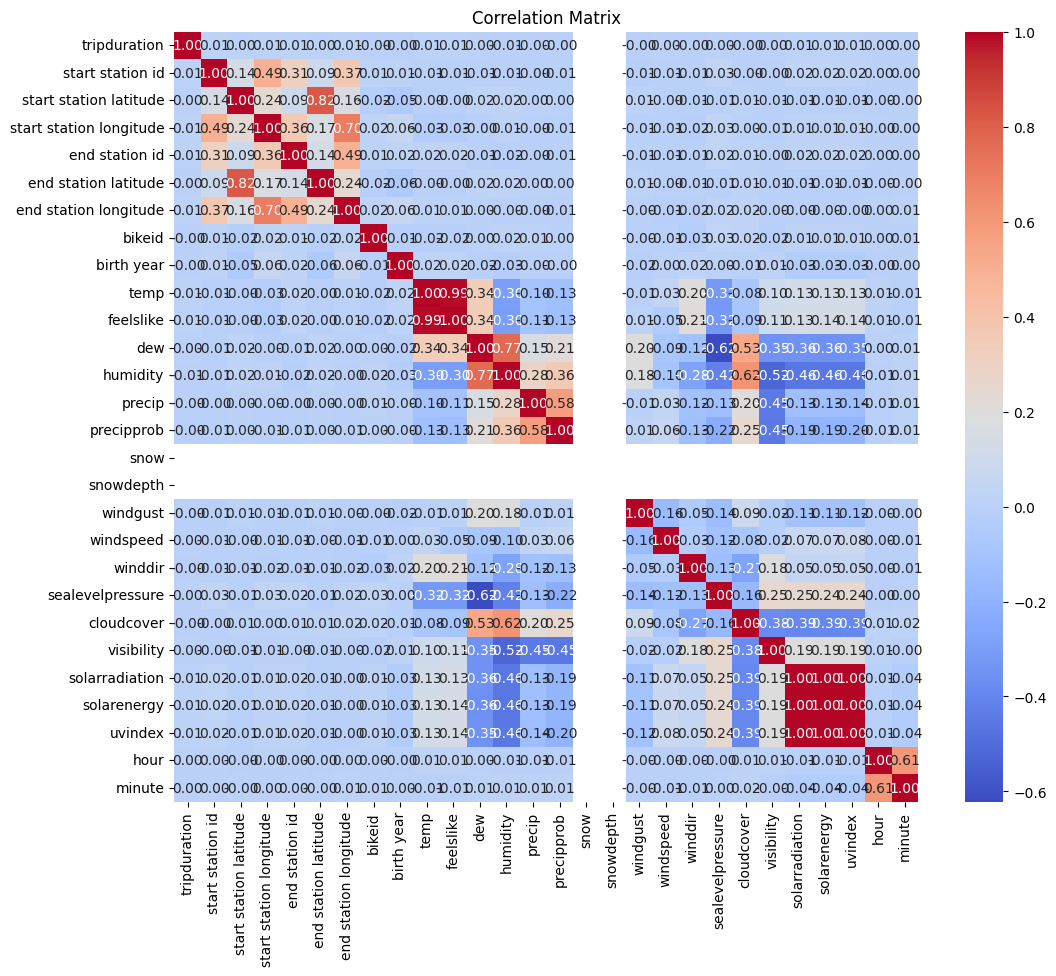

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hour                     1440 non-null   int32  
 1   minute                   1440 non-null   int32  
 2   temp                     1440 non-null   float64
 3   humidity                 1440 non-null   float64
 4   bikeid                   1440 non-null   int64  
 5   solarenergy              1440 non-null   float64
 6   windgust                 1440 non-null   float64
 7   start station id         1440 non-null   int64  
 8   windspeed                1440 non-null   float64
 9   start station latitude   1440 non-null   float64
 10  start station longitude  1440 non-null   float64
 11  winddir                  1440 non-null   float64
 12  cloudcover               1440 non-null   float64
 13  tripduration             1440 non-null   float64
 14  precip                  

In [56]:
data = processBikeDemandDataset("bb-data.csv")
if data is not  None:
    corr_analysis = correlationAnalysis(data)
    model_feature_engineered = build_model_df(corr_analysis)
    Prediction = train_and_predict(model_feature_engineered)
else:
    print('Failed to load dataset')